In [9]:
import cbpro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import arrow
from requests.auth import AuthBase
import plotly.graph_objs as go


pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000


In [10]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff

# Read CSV File

In [11]:
#new_df.to_csv('ETHUSD5M.csv',index=False)

In [155]:
test = pd.read_csv('ETHUSD15M.csv')

test.shape

(163913, 8)

In [156]:
test.head()

,Unnamed: 0,time,low,high,open,close,volume,Date
0,0,1611532800,1384.15,1417.07,1394.04,1415.05,14531.930071,2021-01-25 00:00
1,1,1611531900,1383.69,1401.92,1385.65,1394.00,15134.332706,2021-01-24 23:45
2,2,1611531000,1378.61,1386.80,1382.93,1385.33,5749.605711,2021-01-24 23:30
3,3,1611530100,1376.57,1389.07,1376.57,1382.86,8515.797723,2021-01-24 23:15
4,4,1611529200,1368.62,1381.93,1368.62,1376.47,7457.533536,2021-01-24 23:00


In [157]:
test.drop('Unnamed: 0',axis=1,inplace=True)
test = test.sort_values('Date')

In [158]:
test.head()

,time,low,high,open,close,volume,Date
163912,1464012000,13.85,13.86,13.86,13.85,180.0,2016-05-23 15:00
163911,1464012900,13.85,13.86,13.86,13.85,180.0,2016-05-23 15:15
163910,1464013800,13.85,13.86,13.86,13.85,180.0,2016-05-23 15:30
163909,1464014700,13.85,13.86,13.86,13.85,180.0,2016-05-23 15:45
163908,1464015600,13.85,13.86,13.86,13.85,180.0,2016-05-23 16:00


In [159]:
test = test[['Date','open','high','low','close','volume']].copy()
test.columns = ['Date','Open','High','Low','Close','Volume']

In [160]:
test['avg'] = (test[['Low','High','Close']].sum(axis=1))/3

In [161]:
test.head()

,Date,Open,High,Low,Close,Volume,avg
163912,2016-05-23 15:00,13.86,13.86,13.85,13.85,180.0,13.853333
163911,2016-05-23 15:15,13.86,13.86,13.85,13.85,180.0,13.853333
163910,2016-05-23 15:30,13.86,13.86,13.85,13.85,180.0,13.853333
163909,2016-05-23 15:45,13.86,13.86,13.85,13.85,180.0,13.853333
163908,2016-05-23 16:00,13.86,13.86,13.85,13.85,180.0,13.853333


In [162]:
test['Date'] = pd.to_datetime(test['Date'])

In [163]:
test = test.set_index('Date',drop=True)
test.head(5)

,Open,High,Low,Close,Volume,avg
Date,,,,,,
2016-05-23 15:00:00,13.86,13.86,13.85,13.85,180.0,13.853333
2016-05-23 15:15:00,13.86,13.86,13.85,13.85,180.0,13.853333
2016-05-23 15:30:00,13.86,13.86,13.85,13.85,180.0,13.853333
2016-05-23 15:45:00,13.86,13.86,13.85,13.85,180.0,13.853333
2016-05-23 16:00:00,13.86,13.86,13.85,13.85,180.0,13.853333


In [164]:
#Create my technical analysis indicators which are going to be my features

x = ['Close','Volume','avg']
t1 = 8
t2 = 16
for i in test[x]:

    c1 = 'rtn_' + i
    c2 = 'abs_rtn_' + i
    test[c1] = np.log(test[i]/test[i].shift(1))
    test[c2] = abs(np.log(test[i]/test[i].shift(1)))
    c3 = i + '_std' + str(t1)
    c4 = i + '_std' + str(t2) 
    test[c3] = test[i].rolling(window=t1).std()
    test[c4] = test[i].rolling(window=t2).std()
    
    c5 = c2 + '_' + str(t1) + 'MA'
    c6 = c2 + '_' + str(t2) + 'MA'
    test[c5] = test[c2].rolling(window=t1).mean()
    test[c6] = test[c2].rolling(window=t2).mean()
    c7 = i + '_' + str(t1) + 'EMA'
    c8 = i + '_' + str(t2) + 'EMA'
    test[c7] = test[i].ewm(span=t1,adjust=True).mean()
    test[c8] = test[i].ewm(span=t2,adjust=True).mean()
    c9 = i + '_' + str(t1) + 'MA'
    c10 = i + '_' + str(t2) + 'MA'
    test[c9] = test[i].rolling(window=t1).mean()
    test[c10] = test[i].rolling(window=t2).mean()
    
   
    c11 = 'Diff_' + c8 + c7
    test[c11] = test[c8] - test[c7]
        #Bollinger on Close price
    if i == 'Close' or 'avg':
        
        bol1 = ['BolUp'+c9,'BolDn'+c9]
        bol2 = ['BolUp'+c10,'BolDn'+c10]

        test[bol1[0]] = test[i].rolling(window=t1).mean() + (test[c2]*2.5) 
        test[bol1[1]] = test[i].rolling(window=t1).mean() - (test[c2]*2.5)
        test[bol2[0]] = test[i].rolling(window=t2).mean() + (test[c3]*2.5)
        test[bol2[1]] = test[i].rolling(window=t2).mean() - (test[c3]*2.5) 


In [165]:
#Create the RSI, Relative Strength Indicator 

rsi_period = 14
rsi = pd.DataFrame(test['Close'],index=test.index)
rsi['rtn'] = rsi['Close'].diff(periods=1)
rsi['po_rtn'] = [x if x > 0 else 0 for x in rsi['rtn']]
rsi['neg_rtn'] = [x if x < 0 else 0 for x in rsi['rtn']]
#rsi = rsi.iloc[1:,:]
rsi['RS'] = rsi['po_rtn'].ewm(span=rsi_period).mean()/rsi['neg_rtn'].abs().ewm(span=rsi_period).mean()
rsi['rsi'] = 100-(100/(1+rsi['RS']))

In [166]:
test['RSI_Close'] = rsi['rsi']

In [167]:
test.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'avg', 'rtn_Close',
       'abs_rtn_Close', 'Close_std8', 'Close_std16', 'abs_rtn_Close_8MA',
       'abs_rtn_Close_16MA', 'Close_8EMA', 'Close_16EMA', 'Close_8MA',
       'Close_16MA', 'Diff_Close_16EMAClose_8EMA', 'BolUpClose_8MA',
       'BolDnClose_8MA', 'BolUpClose_16MA', 'BolDnClose_16MA', 'rtn_Volume',
       'abs_rtn_Volume', 'Volume_std8', 'Volume_std16', 'abs_rtn_Volume_8MA',
       'abs_rtn_Volume_16MA', 'Volume_8EMA', 'Volume_16EMA', 'Volume_8MA',
       'Volume_16MA', 'Diff_Volume_16EMAVolume_8EMA', 'BolUpVolume_8MA',
       'BolDnVolume_8MA', 'BolUpVolume_16MA', 'BolDnVolume_16MA', 'rtn_avg',
       'abs_rtn_avg', 'avg_std8', 'avg_std16', 'abs_rtn_avg_8MA',
       'abs_rtn_avg_16MA', 'avg_8EMA', 'avg_16EMA', 'avg_8MA', 'avg_16MA',
       'Diff_avg_16EMAavg_8EMA', 'BolUpavg_8MA', 'BolDnavg_8MA',
       'BolUpavg_16MA', 'BolDnavg_16MA', 'RSI_Close'],
      dtype='object')

In [168]:
#Volume indicator
test['Volume_ratio'] = test['Volume'] / test['Volume_8MA']

#Features to locate the price divergence from the bollinger bands
test['Close_MAs_ratio'] = test['Close_16MA'] / test['Close_8MA']
test['DnBol_Dist_16'] = test['Close'] - test['BolDnClose_16MA']
test['UpBol_Dist_16'] = test['Close'] - test['BolUpClose_16MA']
test['Dist_BolDn_BolUp'] = test['BolUpClose_16MA'] - test['BolDnClose_16MA']

In [169]:
#Average true range calculation, volatility indicator

t3 = 14  #the standard period for daily chart
ATR = pd.DataFrame()
ATR['HighLow'] = test['High'] - test['Low']
ATR['High_Close-1'] = abs(test['High'] - test['Close'].shift(-1))
ATR['Low_Close-1'] = abs(test['Low'] - test['Close'].shift(-1))
ATR['True_Range'] = ATR.max(axis=1)
ATR['ATR'] = ATR['True_Range'].rolling(window=t3).mean()

In [170]:
test['ATR'] = ATR['ATR']

In [171]:
#test = pd.read_csv('data-eth-15min.csv')
#test = test.set_index(pd.to_datetime(test['Date']))

In [172]:
support = pd.DataFrame(test['Close'])
support.head()

,Close
Date,
2016-05-23 15:00:00,13.85
2016-05-23 15:15:00,13.85
2016-05-23 15:30:00,13.85
2016-05-23 15:45:00,13.85
2016-05-23 16:00:00,13.85


In [173]:
#trying to find support support and resistance via the differentiation. We know that a derivative is equal to 0 for 
# minima and maxima. Although it doesnt really work here as price is a random walk
supports = pd.DataFrame()
supports['diff'] = test['Close_8EMA'].diff(3)
supports['lagged_diff'] = supports['diff'].shift(-1)
supports['forward_diff'] = supports['diff'].shift(1)
supports.fillna(0,inplace=True)
supports.head()

,diff,lagged_diff,forward_diff
Date,,,
2016-05-23 15:00:00,0.0,0.0,0.0
2016-05-23 15:15:00,0.0,0.0,0.0
2016-05-23 15:30:00,0.0,0.0,0.0
2016-05-23 15:45:00,0.0,0.0,0.0
2016-05-23 16:00:00,0.0,0.0,0.0


In [174]:
supports.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163913 entries, 2016-05-23 15:00:00 to 2021-01-25 00:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   diff          163913 non-null  float64
 1   lagged_diff   163913 non-null  float64
 2   forward_diff  163913 non-null  float64
dtypes: float64(3)
memory usage: 5.0 MB


In [175]:
supports['pivot'] = np.where(((supports['lagged_diff'] < 0) & (supports['forward_diff'] > 0)), 1,
                                np.where(((supports['lagged_diff'] > 0) & (supports['forward_diff'] < 0)), 2, 0))

In [176]:
supports.head()

,diff,lagged_diff,forward_diff,pivot
Date,,,,
2016-05-23 15:00:00,0.0,0.0,0.0,0
2016-05-23 15:15:00,0.0,0.0,0.0,0
2016-05-23 15:30:00,0.0,0.0,0.0,0
2016-05-23 15:45:00,0.0,0.0,0.0,0
2016-05-23 16:00:00,0.0,0.0,0.0,0


In [177]:
test['pivot'] = supports['pivot']

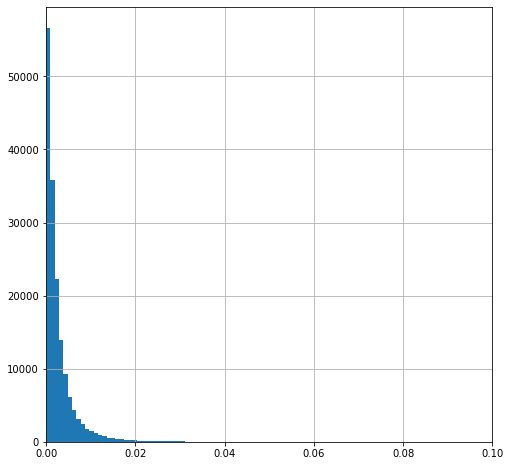

In [178]:
fig, ax = plt.subplots(figsize=(8,8))
test['abs_rtn_avg'].hist(bins=500)
plt.xlim(0,0.1)
plt.show()

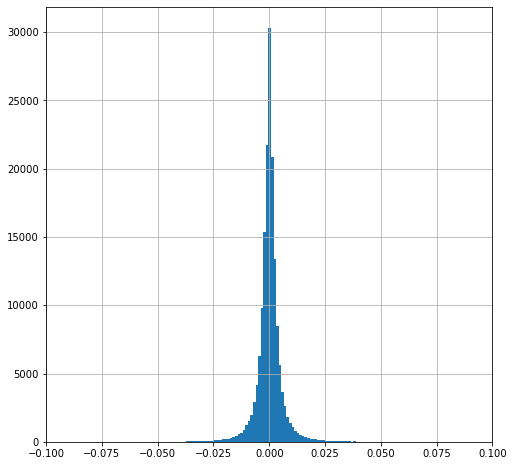

In [179]:
fig, ax = plt.subplots(figsize=(8,8))
test['Close'].pct_change(periods=1).hist(bins=300)
plt.xlim(-0.10,0.10)
plt.show()

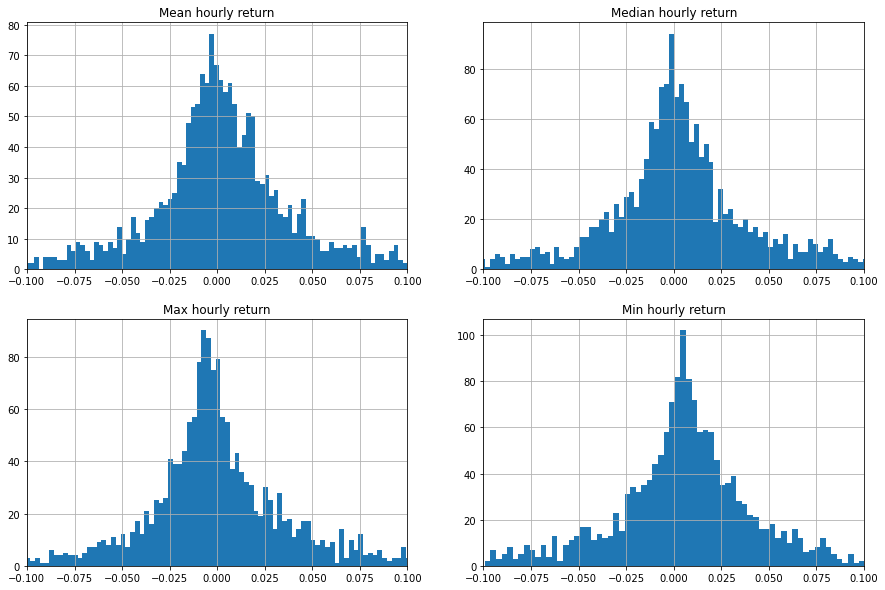

In [180]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
test.resample('D').mean()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[0,0])
test.resample('D').median()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[0,1])
test.resample('D').max()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[1,0])
test.resample('D').min()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[1,1])
ax[0,0].set_title('Mean hourly return')
ax[0,1].set_title('Median hourly return')
ax[1,0].set_title('Max hourly return')
ax[1,1].set_title('Min hourly return')
ax[0,0].set_xlim(-0.10,0.10)
ax[0,1].set_xlim(-0.10,0.10)
ax[1,0].set_xlim(-0.10,0.10)
ax[1,1].set_xlim(-0.10,0.10)
plt.show()

In [181]:
trace0 = go.Scatter(x=test.index, y=test['avg'], name='avg', line=dict(color='lime'))
trace1 = go.Scatter(x=test.index, y=test['avg_7MA'], name='60MA', line=dict(color='grey'))
#trace2 = go.Scatter(x=test.index, y=test['avg'].rolling(window=96).mean(), name='96MA', line=dict(color='red'))
#trace3 = go.Scatter(x=test.index, y=test['BolUpavg_96MA'], 
#                    name='Bup', line=dict(color='blue'),marker=dict(size = 15, color = 'blue', symbol = 'cross'))
#trace4 = go.Scatter(x=test.index, y=test['BolDnavg_96MA'], 
#                    name='Bdn', line=dict(color='blue'),marker=dict(size = 15, color = 'blue', symbol = 'cross'))

#trace4 = go.Scatter(x=test.index, y=test['pivot'], 
#                    name='Bdn', line=dict(color='blue'),marker=dict(size = 15, color = 'blue', symbol = 'cross'))

#data = [trace0, trace1, trace2,trace3, trace4]
data = [trace0, trace1]
layout = dict(
            title='ETH',
              xaxis = dict(
        range = [min(test.index),max(test.index)]
              )
             )

fig = dict(data=data, layout=layout)
py.iplot(fig)

KeyError: 'avg_7MA'

In [182]:
#Create my target variable: 
# return for the next 30min (15min data),
# return for the next 4h (hourly data), 
# return the next 2d (daily data),
# Then make a column that says if the return is positive or negative (flat return included) .
test['Return_1h'] = test['Close'].ewm(span=1).mean().pct_change(4).shift(-5)

In [183]:
test[['Close','Return_1h']].head()

,Close,Return_1h
Date,,
2016-05-23 15:00:00,13.85,0.0
2016-05-23 15:15:00,13.85,0.0
2016-05-23 15:30:00,13.85,0.0
2016-05-23 15:45:00,13.85,0.0
2016-05-23 16:00:00,13.85,0.0


In [184]:
test['Return_1h'].describe()

count    163908.000000
mean          0.000187
std           0.012229
min          -0.243722
25%          -0.003863
50%           0.000000
75%           0.004161
max           0.352399
Name: Return_1h, dtype: float64

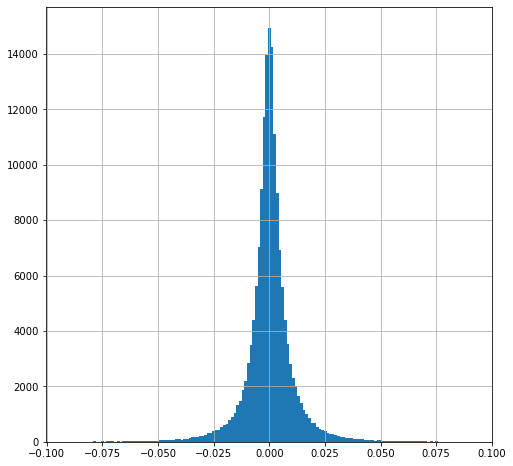

In [185]:
fig, ax = plt.subplots(figsize=(8,8))
test['Return_1h'].hist(bins=500)
plt.xlim(-0.1003,0.1003)
plt.show()

In [186]:
test[test['Return_1h'] == 0.000000].loc[:,'Return_1h']

Date
2016-05-23 15:00:00    0.0
2016-05-23 15:15:00    0.0
2016-05-23 15:30:00    0.0
2016-05-23 15:45:00    0.0
2016-05-23 16:00:00    0.0
2016-05-23 16:15:00    0.0
2016-05-23 16:30:00    0.0
2016-05-23 16:45:00    0.0
2016-05-23 17:00:00    0.0
2016-05-23 17:15:00    0.0
2016-05-23 17:30:00    0.0
2016-05-23 17:45:00    0.0
2016-05-23 18:00:00    0.0
2016-05-23 18:15:00    0.0
2016-05-23 18:30:00    0.0
2016-05-23 18:45:00    0.0
2016-05-23 19:00:00    0.0
2016-05-23 19:15:00    0.0
2016-05-23 19:30:00    0.0
2016-05-23 19:45:00    0.0
2016-05-23 20:00:00    0.0
2016-05-23 20:15:00    0.0
2016-05-23 20:30:00    0.0
2016-05-23 20:45:00    0.0
2016-05-23 21:00:00    0.0
2016-05-23 21:15:00    0.0
2016-05-23 21:30:00    0.0
2016-05-23 22:45:00    0.0
2016-05-23 23:00:00    0.0
2016-05-23 23:15:00    0.0
2016-05-24 00:45:00    0.0
2016-05-24 01:00:00    0.0
2016-05-24 01:15:00    0.0
2016-05-24 01:30:00    0.0
2016-05-24 01:45:00    0.0
2016-05-24 02:00:00    0.0
2016-05-24 02:15:00    

In [187]:
test['BuyorSell'] = [-1 if x <= 0 else 1 for x in test['Return_1h']]

In [188]:
# I am including the flat return to the positive return target variable in the model notebook.
test['BuyorSell'].value_counts(normalize=True)

-1    0.503822
 1    0.496178
Name: BuyorSell, dtype: float64

In [190]:
#Saving the finale data
test.to_csv('data-eth-15min.csv')